Report the land cover classification and primary forest loss detection accuracy

In [1]:
import numpy as np
import os
from os.path import join
import pandas as pd

from accuracy_assessment.good_practice_accuracy_assessment import (generate_good_practice_matrix,
                                                                   plot_df_confusion, get_adjusted_area_and_margin_of_error)

C:\Users\64937\AppData\Local\Temp\ipykernel_48000\3025148787.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pwd = os.getcwd()
rootpath = os.path.abspath(os.path.join(pwd, '..'))

filename_accuracy_assessment_tabel = join(rootpath, 'results', 'accuracy_assessment_table.xlsx')

landcover_system = {'1': 'developed',
                    '2': 'primary wet forest',
                    '3': 'primary dry forest',
                    '4': 'secondary forest',
                    '5': 'shrub/grass',
                    '6': 'water',
                    '7': 'wetland',
                    '8': 'other'}
reverse_lc_system = {v: int(k) for k, v in landcover_system.items()}

filename_lc_pct = join(rootpath, 'results', 'land_cover_pct.xlsx')
df_lc_pct = pd.read_excel(filename_lc_pct, sheet_name='Hispaniola')

# get the count and weight
array_count_lc = df_lc_pct.iloc[:, 2:10].sum().values
array_weight_lc = array_count_lc / np.nansum(array_count_lc)

# read the land cover assessment data
df_lc_assessment = pd.read_excel(filename_accuracy_assessment_tabel, sheet_name='landcover_validation_record')

# get the map results
array_lc_map = df_lc_assessment['map_type'].values
array_lc_map = np.array([reverse_lc_system.get(i, -999) for i in array_lc_map])

# get the reference results
exclude_flag = df_lc_assessment['final_exclude_flag'].values == True
array_lc_reference = df_lc_assessment['final_lc'].values
array_lc_reference = np.array([reverse_lc_system.get(i, -999) for i in array_lc_reference])

# final data to report the accuracy
mask_exclude = (array_lc_map == -999) | (array_lc_reference == -999) | exclude_flag

array_lc_map_final = array_lc_map[~mask_exclude]
array_lc_reference_final = array_lc_reference[~mask_exclude]

# count-based confusion matrix
categories = np.arange(1, len(array_weight_lc) + 1)

array_lc_map_final = pd.Categorical(array_lc_map_final, categories=categories)  # define the categories to avoid missing categories in the confusion matrix
array_lc_reference_final = pd.Categorical(array_lc_reference_final, categories=categories)

df_confusion_lc = pd.crosstab(array_lc_map_final, array_lc_reference_final, rownames=['Map'], colnames=['Reference'], dropna=False)
overall_accuracy = np.trace(df_confusion_lc.values) / np.sum(df_confusion_lc.values)

print(f'number of agreement pixels: {np.trace(df_confusion_lc.values)} / {df_confusion_lc.values.sum()}')
print(f'count-based overall accuracy {overall_accuracy}')

# area-based confusion matrix
df_err_adjust_lc = generate_good_practice_matrix(df_confusion_lc.values, array_weight_lc, array_count_lc)
print('adjusted overall accuracy {}'.format(df_err_adjust_lc.loc['PA', 'UA']))


number of agreement pixels: 295 / 371
count-based overall accuracy 0.7951482479784366
adjusted overall accuracy 0.8052056284843757


C:\Users\64937\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


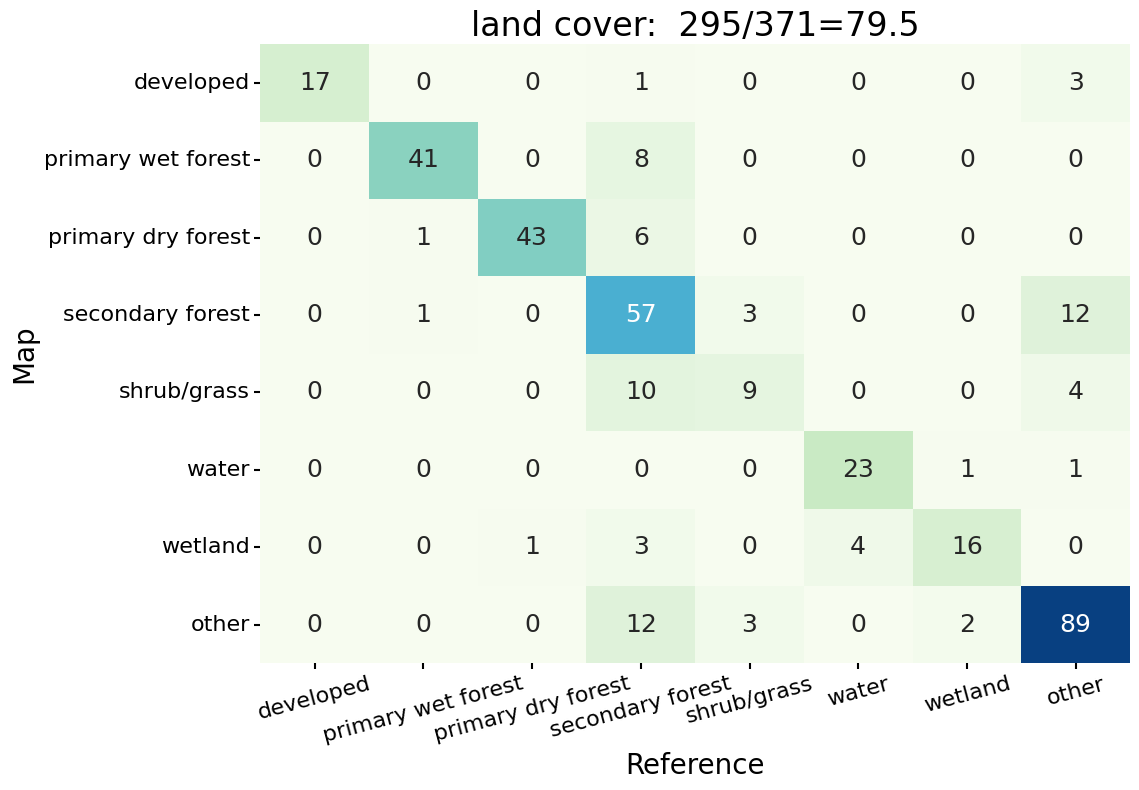

In [3]:
plot_df_confusion(df_confusion_lc.values, stratum_des=landcover_system, title='land cover', figsize=(11.5, 8))

In [4]:
df_err_adjust_lc

,1,2,3,4,5,6,7,8,total,UA,UA_uncertainty,n_count,weight
1,0.011622,0.000000,0.000000,0.000684,0.000000,0.000000,0.000000,0.002051,0.014357,0.809524,0.172098,21.0,0.014357
2,0.000000,0.029724,0.000000,0.005800,0.000000,0.000000,0.000000,0.000000,0.035524,0.836735,0.104563,49.0,0.035524
3,0.000000,0.000139,0.005987,0.000835,0.000000,0.000000,0.000000,0.000000,0.006961,0.860000,0.097156,50.0,0.006961
4,0.000000,0.005355,0.000000,0.305213,0.016064,0.000000,0.000000,0.064255,0.390887,0.780822,0.095557,73.0,0.390887
5,0.000000,0.000000,0.000000,0.010407,0.009366,0.000000,0.000000,0.004163,0.023936,0.391304,0.203940,23.0,0.023936
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.008338,0.000363,0.000363,0.009064,0.920000,0.108540,25.0,0.009064
7,0.000000,0.000000,0.000250,0.000750,0.000000,0.001000,0.003998,0.000000,0.005997,0.666667,0.192657,24.0,0.005997
8,0.000000,0.000000,0.000000,0.058107,0.014527,0.000000,0.009684,0.430957,0.513275,0.839623,0.070190,106.0,0.513275
total,0.011622,0.035218,0.006236,0.381795,0.039957,0.009338,0.014045,0.501789,100.000000,NaN,NaN,NaN,NaN
PA,1.000000,0.844004,0.959932,0.799416,0.234411,0.892960,0.284664,0.858842,NaN,0.805206,NaN,NaN,NaN


In [5]:
# get area adjustment results and margin of error
get_adjusted_area_and_margin_of_error(df_confusion_lc.values, df_err_adjust_lc, array_count_lc, confidence_interval=1.96)

mapped area (km2): [  29149.47   72126.65   14133.74  793647.96   48599.36   18402.36
   12176.58 1042143.15]
adjusted area (km2): [  23597.19   71505.44   12662.38  775188.32   81127.43   18959.6
   28516.89 1018822.03]
map bias: map area - adjusted area [  5552.28    621.22   1471.37  18459.64 -32528.07   -557.24 -16340.31
  23321.12]
standard_area_proportion [0.00126059 0.00568179 0.00042604 0.02501599 0.0126028  0.00068491
 0.00685029 0.02518915]
standard error of area (km2) estimation at 95% confidence level [  5016.57  22610.93   1695.44  99552.21  50153.39   2725.64  27261.03
 100241.31]


Primary forest loss detection accuracy report

In [6]:
pf_loss_dict = {'1': 'Other',
                '2': 'PF loss'}
reverse_pf_loss_system = {v: int(k) for k, v in pf_loss_dict.items()}

# get the count and weight
count_pf_loss = df_lc_pct.iloc[0, 3:5].sum() - df_lc_pct.iloc[-1, 3:5].sum()
count_other = df_lc_pct.loc[0, 'TOTAL'] - count_pf_loss

array_count_pf_loss = np.array([count_other, count_pf_loss])
array_weight_pf_loss = array_count_pf_loss / np.nansum(array_count_pf_loss)

# read the PF loss assessment data
df_pf_loss_assessment = pd.read_excel(filename_accuracy_assessment_tabel, sheet_name='pf_loss_validation_record')

# get the map results
array_pf_loss_map = df_pf_loss_assessment['map_type'].values
array_pf_loss_map = np.array([reverse_pf_loss_system.get(i, -999) for i in array_pf_loss_map])

# get the reference results
exclude_flag_pf_loss = df_pf_loss_assessment['final_exclude_flag'].values == True
array_pf_loss_reference = df_pf_loss_assessment['final_val_label'].values
array_pf_loss_reference = np.array([reverse_pf_loss_system.get(i, -999) for i in array_pf_loss_reference])

# final data to report the accuracy
mask_exclude_pf_loss = (array_pf_loss_map == -999) | (array_pf_loss_reference == -999) | exclude_flag_pf_loss
array_pf_loss_map_final = array_pf_loss_map[~mask_exclude_pf_loss]
array_pf_loss_reference_final = array_pf_loss_reference[~mask_exclude_pf_loss]

# count-based confusion matrix
categories = np.array([1, 2])

array_pf_loss_map_final = pd.Categorical(array_pf_loss_map_final, categories=categories)  # define the categories to avoid missing categories in the confusion matrix
array_pf_loss_reference_final = pd.Categorical(array_pf_loss_reference_final, categories=categories)

df_confusion_pf_loss = pd.crosstab(array_pf_loss_map_final, array_pf_loss_reference_final, rownames=['Map'], colnames=['Reference'], dropna=False)
overall_accuracy = np.trace(df_confusion_pf_loss.values) / np.sum(df_confusion_pf_loss.values)

print(f'number of agreement pixels: {np.trace(df_confusion_pf_loss.values)} / {df_confusion_pf_loss.values.sum()}')
print(f'count-based overall accuracy {overall_accuracy}')

# area-based confusion matrix
df_err_adjust_pf_loss = generate_good_practice_matrix(df_confusion_pf_loss.values, array_weight_pf_loss, array_count_pf_loss)
print('adjusted overall accuracy {}'.format(df_err_adjust_pf_loss.loc['PA', 'UA']))

ua_pf_loss = df_err_adjust_pf_loss.loc[2, 'UA']
pa_pf_loss = df_err_adjust_pf_loss.loc['PA', 2]
print('user accuracy for PF loss: {}'.format(ua_pf_loss))
print('producer accuracy for PF loss: {}'.format(pa_pf_loss))

number of agreement pixels: 449 / 480
count-based overall accuracy 0.9354166666666667
adjusted overall accuracy 0.9941512749201064
user accuracy for PF loss: 0.6875
producer accuracy for PF loss: 0.7363760310358616


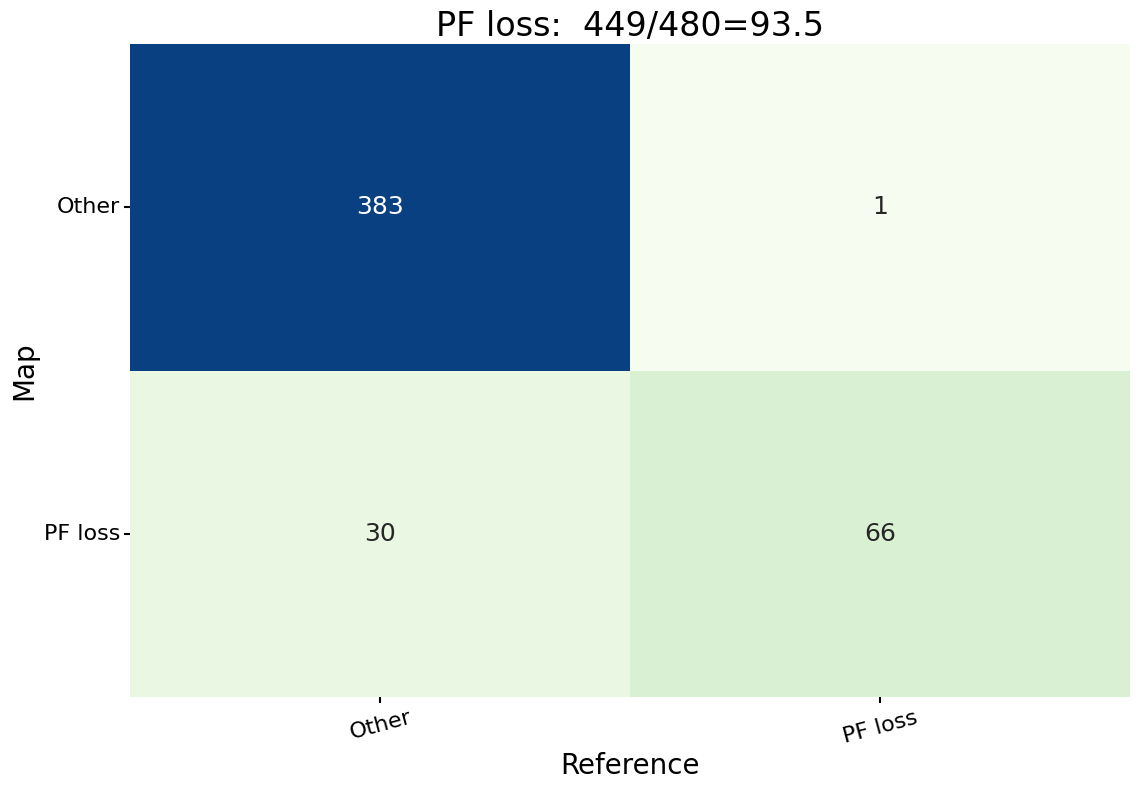

In [7]:
plot_df_confusion(df_confusion_pf_loss.values, stratum_des=pf_loss_dict, title='PF loss', figsize=(11.5, 8))

In [8]:
df_err_adjust_pf_loss

,1,2,total,UA,UA_uncertainty,n_count,weight
1,0.986953,0.002577,0.98953,0.997396,0.005104,384.0,0.98953
2,0.003272,0.007198,0.01047,0.687500,0.093209,96.0,0.01047
total,0.990225,0.009775,100.00000,NaN,NaN,NaN,NaN
PA,0.996696,0.736376,NaN,0.994151,NaN,NaN,NaN
PA_uncertainty,0.000982,0.381397,NaN,NaN,0.005144,NaN,NaN
n_count,413.000000,67.000000,NaN,NaN,NaN,480.0,NaN


In [9]:
get_adjusted_area_and_margin_of_error(df_confusion_pf_loss.values, df_err_adjust_pf_loss, array_count_pf_loss, confidence_interval=1.96)

mapped area (km2): [74411.91   787.32]
adjusted area (km2): [74464.17   735.07]
map bias: map area - adjusted area [-52.26  52.26]
standard_area_proportion [0.00262456 0.00262456]
standard error of area (km2) estimation at 95% confidence level [386.84 386.84]


Report the major driver of primary forest loss in Hispaniola

In [10]:
pf_loss_adjusted_area = df_err_adjust_pf_loss.loc['total', 2] * np.nansum(array_count_pf_loss) * 900 / 1000000
print(f'PF loss area (adjusted): {pf_loss_adjusted_area:.1f} km2')

array_pf_loss_driver = df_pf_loss_assessment['final_pf_loss_driver'].values[~mask_exclude_pf_loss]
array_pf_loss_driver = array_pf_loss_driver.astype(str)

array_pf_loss_driver_name, array_pf_loss_driver_count = np.unique(array_pf_loss_driver, return_counts=True)
array_pf_loss_driver_name = array_pf_loss_driver_name[0:-1]
array_pf_loss_driver_count = array_pf_loss_driver_count[0:-1]

array_pf_loss_driver_percent = array_pf_loss_driver_count / array_pf_loss_driver_count.sum() * 100

area_pf_loss_area_each_driver = np.zeros(len(array_pf_loss_driver_name), dtype=float)
for i in range(0, len(array_pf_loss_driver_name)):
    area_pf_loss_area_each_driver[i] = array_pf_loss_driver_percent[i] / 100 * pf_loss_adjusted_area

    print(f'{array_pf_loss_driver_name[i]}: {array_pf_loss_driver_count[i]} / {np.sum(array_pf_loss_driver_count)} ({array_pf_loss_driver_percent[i]:.2f}%), {area_pf_loss_area_each_driver[i]:.1f} km2')


PF loss area (adjusted): 735.1 km2
Fire: 44 / 67 (65.67%), 482.7 km2
Hurricane: 6 / 67 (8.96%), 65.8 km2
Landslide: 2 / 67 (2.99%), 21.9 km2
Other: 1 / 67 (1.49%), 11.0 km2
Tree-cutting: 14 / 67 (20.90%), 153.6 km2
